# Comparing two samples

Up to this point we have been interested in *one-sample* problems.  In particular, we wanted to know if our one sample (Midtown) had a mean different to that of some hypothesized population value (the mean of Manhattan).  But we often have situations where we want to compare *two* samples, perhaps most commonly where one receives a treatment and one does not, and we want to talk about the differences between those groups.  Of course, two sample comparisons may also be interesting in a purely *descriptive* sense---for example, the incomes of Democrat v Republican voters, or the weights of birds with respect to their sexes.

## Smoking v non-Smoking Mothers

Our worked example is of smoking versus non-smoking mothers: that defines the groups.  The outcome of interest is (average) weights of their babies.  In general, we think mothers who smoke have babies with lower birth weights (which is undesirable for health reasons), and we want to see if the data is consistent with this hypothesis.

First things first, let's load up the data. We will work with two variables, the maternal smoking status and birth weight of that mother's child. We will do this after loading some libraries we might need.

In [2]:
import numpy as np
import matplotlib.pyplot as plots 
import pandas as pd

births = pd.read_csv('data/baby.csv')
smoking_and_birthweight = births[['Maternal.Smoker', 'Birth.Weight']]

There are 1174 mothers, 715 who were non-smoking, 469 who smoked.  Let's create those two groups.  It is always a good idea to plot our data, so let's start by using yellow (sorry, "gold") for the non-smokers, and blue for the smokers:

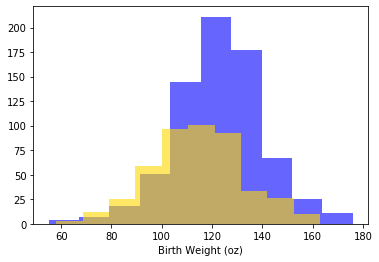

In [3]:
smoker_bw =  smoking_and_birthweight[smoking_and_birthweight['Maternal.Smoker'] == True]
nsmoker_bw =  smoking_and_birthweight[smoking_and_birthweight['Maternal.Smoker'] == False]


kwargs = dict(alpha=0.6)
plots.hist(nsmoker_bw['Birth.Weight'], **kwargs, color='blue', label='Non-Smoker')
plots.hist(smoker_bw['Birth.Weight'] ,**kwargs, color='gold', label='Smoker')
plots.xlabel("Birth Weight (oz)")
plots.show()

Looks like the blue (non smoker) mean is a little higher --- it is as if the blue distribution is the gold distribution, but pulled up and shifted right.  But we can confirm this by just looking at the means directly:

In [9]:
means_frame = smoking_and_birthweight.groupby(['Maternal.Smoker'])['Birth.Weight']\
    .mean().to_frame()
means_frame

Birth.Weight
Maternal.Smoker              
False              123.085315
True               113.819172

In words: the smoker mean baby weight is 113 oz; the non-smoker mean is 123 oz. Let's be more systematic: 
- the **null hypothesis** is that, in the population, there is no difference (in means) between the groups.  That is, we just drew unusual samples.
- the **alternative hypothesis** is that, in the population, there is a *difference* (in means). In fact, a directional hypothesis seems reasonable: smoker's babies weigh less on average.

Our **test statistic** will be the difference between the two groups.  Specifically: 


$$
\mbox{mean weight of smoking group} - \mbox{mean weight of non-smoking group}
$$


We will simulate that under the null of no difference.  Our **observed statistic** is the *actual* difference for our samples, which is $-9.27$ oz. In code:

In [10]:
observed_difference =  means_frame.iloc[1,0]- means_frame.iloc[0,0] 

## Procedure

To reiterate, we observed an actual difference, and we want to know if a difference as large as this (or larger) is compatible with the null being true.  Crudely: if it is possible, we fail to reject the null.  If it isn't possible, we reject the null.

We go about this in a way slightly different to previously, however.  First, suppose that the null was true.  This would mean there was *no* difference between the groups, which would mean the label "smoker" v "non-smoker" was completely uninformative about what baby weight we would expect a mother to have.  That is, finding out whether someone was a smoker or non-smoker would not give us any more information as to whether their baby was likely to be heavier or lighter.

But if *this* is true, then we can just *randomly assign* labels to people, and then calculate the difference between the groups defined that "random" way.  That will be equivalent to the difference we would expect under the null.  

So, let's find a way to give every observation a random label (smoker or non-smoker) many many times, and then see what differences in outcomes this would suggest as the null. Sometimes when we allocate random labels, the difference (smoking - non-smoking) will be positive; sometimes it will be negative; but on average it will be zero.  The key thing is that we will now know the distribution of the difference *if* the null were true.

### A Toy Example
Side note:  a "toy" example is a very simple example that can be examined in detail such that the basic idea is readily understood.  In our case, suppose we have three observations in our data: one smoker, two non-smokers.  Their smoking status is $X$, and their outcome (baby weight) is $Y$:

|Y | X |
|---|:---|
|10.1 | smoker |
|12.3| non-smoker|
|11.4| non-smoker|

For this sample the difference in means is $10.1 - 11.85 = -1.75$oz.

Keep the $Y$ column the same, and just randomly shuffle the labels, then calculate the difference, $D$.  

|Y | X |
|---|:---|
|10.1 | non-smoker |
|12.3| smoker|
|11.4| non-smoker|

$D=1.55$.  Let's shuffle them again:


|Y | X |
|---|:---|
|10.1 | non-smoker |
|12.3| non-smoker|
|11.4| smoker|

and $D=0.2$.  Let's shuffle one more time:

|Y | X |
|---|:---|
|10.1 | smoker |
|12.3| non-smoker|
|11.4| non-smoker|

and $D=-1.75$.

We could gather all these values of $D$ and plot them: this would be our distribution of the difference under the null.

## Permutation Inference
The idea above is called **permutation inference**. It is 

> a way of re-sampling and rearranging our data, such that we can test statistical hypotheses.

For our current problem, we will shuffle or "permute" the labels and each time record the difference between smokers and non-smokers.  We will do this *in proportion* to the frequency of the original labels in the data; so if, say, 39% of the subjects are smokers and 61% are non-smokers, we will randomly allocate 39% of the shuffled sample to be smokers, and 61% as non-smokers.

We will do this many, many times and then look at the histogram of the differences---this will represent our test statistic under the null. We will compare that null to our observed difference, and draw conclusions about statistical significance.  

First, we will need a function that takes the difference in means between two groups:

In [11]:
def difference_of_means(our_frame=smoking_and_birthweight, group='Maternal.Smoker',
                        variable='Birth.Weight'):
    mean_frame = our_frame.groupby([group])[variable].mean().to_frame()
    mean_diff = mean_frame.iloc[1,0] - mean_frame.iloc[0,0]
    return(mean_diff)

Then, we need a function that keeps the birth weight column constant, but shuffles the smoker/non-smoker labels:

In [12]:
def shuffle_labels(our_frame=smoking_and_birthweight):
    our_frame2 = pd.DataFrame(our_frame)
    shuff_lab = our_frame["Maternal.Smoker"].sample(frac=1)
    shuff_lab.reset_index(inplace=True, drop=True) # ridiculous panda syntax
    our_frame2['Shuffled_label'] = shuff_lab
    return(our_frame2)

Those functions are the building blocks.  We now need a function that combines them: that is, that shuffles the labels, and then takes the difference in means between the groups it creates.  Here it is:

In [14]:
def one_sim_time(our_frame=smoking_and_birthweight):
    shuff_frame = shuffle_labels(our_frame)
    dm= difference_of_means(shuff_frame, group='Shuffled_label')
    return(dm)

We will create an array to take the re-sampled means (called `null_differences`), and then run the shuffling function a large number (say, 4000) times:

In [15]:
null_differences = ([])

repetitions = 4000
for i in np.arange(repetitions):
    new_difference = one_sim_time(smoking_and_birthweight)
    null_differences = np.append(null_differences, new_difference)   

Now, let's plot the null distribution, `null_differences` and put the observed difference on that plot in red:

In [16]:
plots.hist(null_differences, color="darkblue",range=[-10, 4], bins=25)
plots.scatter(observed_difference, 0, color='red', s=200);
plots.ylim([-40, None])
plots.xlabel('Difference Btwn Group Means')
plots.ylabel('n cases')
plots.show()

We will not do a formal test here, because it is apparent from the plot that the null distribution *never* overlaps with the observed difference.  Another way to put this is that the p-value is essentially *zero* (as usual, it is not *exactly* zero---we just did not do enough simulations to ever get one that was lower).  That is, the probability that we would see an observed difference like this, assuming that there is no real difference between smokers and non-smokers in the population, is *extremely* small.

### Causal Claims?
Put differently, there is a statistically significant difference between smoker and non-smoker baby weights.  Does this mean that we have shown that smoking *causes* baby weights to be lower?  Not definitively, no: perhaps there is some confounder that causes both smoking and lower baby weights.  But our evidence so far is consistent with a causal story.  